# Sentiment analysis and Topic modeling on airline tweets

# Background

## What is twitter

<img twitter src="https://www.paho.org/sites/default/files/styles/flexslider_full/public/2020-06/twitter-banner-1500px.jpg?h=4f5b30f1&itok=IYdGFRGN" />

**Twitter** is an American microblogging and social networking service on which users post and interact with messages known as "tweets". Registered users can post, like and retweet tweets, but unregistered users can only read them. Users access Twitter through its website interface or its mobile-device application software("app"), though the service could also be accessed via SMS before April 2020. Twitter, Inc. is based in San Francisco, California, and has more than 25 offices around the world. Tweets were originally restricted to 140 characters, but was doubled to 280 for non-CJK languages in November 2017. Audio and video tweets remain limited to 140 seconds for most accounts.

## What is sentiment analysis

<img src="https://www.revuze.it/wp-content/uploads/2019/07/sentiment-analysis-Featured-768x432.png" />

**Sentiment analysis** (also known as opinion mining or emotion AI) is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from matplotlib_venn import venn2
import joblib

#NLP libraries
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

#wordsegment library for hashtag segmentation
import wordsegment
from wordsegment import load, segment

style.use('seaborn-white')
sns.set_context(context='talk')


%matplotlib inline

# Exploratory Data Analysis
Before moving on to the machine learning model, let's look at what we have in hand. The "DATA"

## Metadata exploration

In [2]:
tweet = pd.read_csv('../dataset/Tweets.csv', parse_dates= ['tweet_created'])
tweet.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)


In [3]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype                                 
---  ------                        --------------  -----                                 
 0   tweet_id                      14640 non-null  int64                                 
 1   airline_sentiment             14640 non-null  object                                
 2   airline_sentiment_confidence  14640 non-null  float64                               
 3   negativereason                9178 non-null   object                                
 4   negativereason_confidence     10522 non-null  float64                               
 5   airline                       14640 non-null  object                                
 6   airline_sentiment_gold        40 non-null     object                                
 7   name                          14640 non-null  object                        

In [4]:
tweet.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

The core of the project will focus on extracting sentiment from tweets. However, some features such as **retweet_count, tweet_created(date and time)** could be potentially used to enhance the prediction.

In [5]:
tweet['tweet_created'].describe(datetime_is_numeric=True)

count                                  14640
mean     2015-02-21 11:33:24.781215744-08:00
min                2015-02-16 23:36:05-08:00
25%      2015-02-19 15:54:05.750000128-08:00
50%         2015-02-22 04:44:35.500000-08:00
75%                2015-02-23 08:04:11-08:00
max                2015-02-24 11:53:37-08:00
Name: tweet_created, dtype: object

Data was collected from short time period from 16th to 24th February of 2015

### Tweet messages

In [6]:
tweet['char_length'] = tweet['text'].map(lambda x: len(x))
tweet['word_length'] = tweet['text'].map(lambda x: len(x.split()))
tweet.groupby('airline_sentiment')[['char_length','word_length']].describe()

char_length                                            \
                        count        mean        std   min   25%    50%   
airline_sentiment                                                         
negative               9178.0  113.947919  30.719006  12.0  96.0  126.0   
neutral                3099.0   87.359471  37.682903  12.0  57.0   87.0   
positive               2363.0   86.082945  39.482103  12.0  52.0   86.0   

                                word_length                                  \
                     75%    max       count       mean       std  min   25%   
airline_sentiment                                                             
negative           138.0  176.0      9178.0  19.686206  5.944701  2.0  16.0   
neutral            123.0  167.0      3099.0  14.408842  6.962293  2.0   9.0   
positive           124.0  186.0      2363.0  14.013119  7.039221  2.0   8.0   

                                     
                    50%   75%   max  
airline_sentiment                    
negative           21.0  24.0  36.0  
neutral            14.0  20.0  31.0  
positive           14.0  20.0  31.0

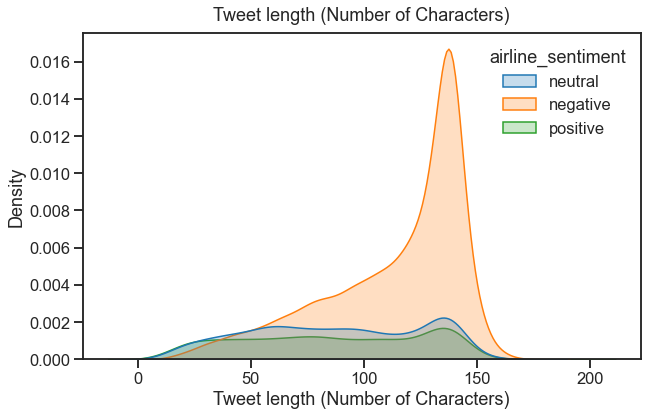

In [7]:
plt.figure(figsize=(10,6))
t = sns.kdeplot(x='char_length',hue='airline_sentiment', fill=True, data=tweet, hue_order=['neutral','negative','positive'])
t.set_title('Tweet length (Number of Characters)',y = 1.02)
t.set_xlabel('Tweet length (Number of Characters)');

>Definition of a Character from [twitter developer site](https://developer.twitter.com/en/docs/counting-characters)  
In most cases, the text content of a **Tweet can contain up to 280 characters** or Unicode glyphs. Some glyphs will count as more than one character.

Although twitter can handle upto 280 characters, positive and neutral sentiment tweet distributed nearly uniform in range of 12-150 charasters, whereas the negative tweet tends to contais longer message with the median at 126 characters and the peak around 140 characters.

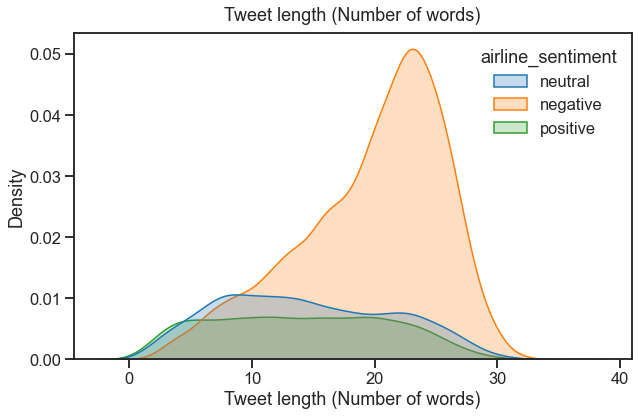

In [8]:
plt.figure(figsize=(10,6))
t = sns.kdeplot(x='word_length',hue='airline_sentiment', fill=True, data=tweet, hue_order=['neutral','negative','positive'])
t.set_title('Tweet length (Number of words)',y = 1.02)
t.set_xlabel('Tweet length (Number of words)');

The similar trend has been observed for neutral and positive tweet (nearly uniform distribution). On the other hand, negative tweets has a significant higher word count.

Note: Twitter policy does not limit maximum number of words per tweet. 

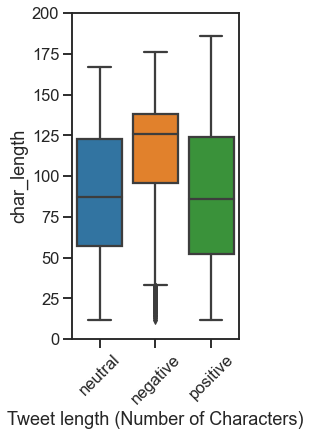

In [9]:
plt.figure(figsize=(3,6))
g = sns.boxplot(y='char_length', x='airline_sentiment', data=tweet, order=['neutral','negative','positive'])
g.set_ylim(0,200)
g.set_xlabel('Tweet length (Number of Characters)');
g.set_xticklabels(g.get_xticklabels(), rotation = 45);

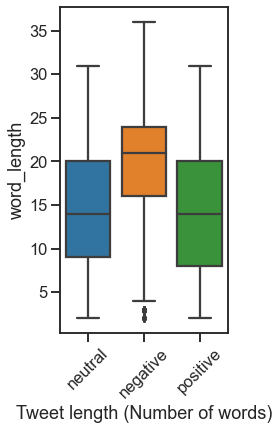

In [10]:
plt.figure(figsize=(3,6))
g = sns.boxplot(y='word_length', x='airline_sentiment', data=tweet, order=['neutral','negative','positive'])
g.set_xlabel('Tweet length (Number of words)');
# g.set_ylim(0,200)
g.set_xlabel('Tweet length (Number of words)');
g.set_xticklabels(g.get_xticklabels(), rotation = 45);

Interesting Findings:

- Negative sentiment tweets contains both higher in character count and word count than neutral and negative tweets.

### Sentiment vs Date and Time of tweet

In [11]:
tweet['tweet_created'] = pd.to_datetime(tweet['tweet_created'])
tweet.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,char_length,word_length
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada),35,4
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada),72,9
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada),71,12


In [12]:
tweet['tweet_created'].describe()

<ipython-input-12-bf69405eebce>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tweet['tweet_created'].describe()


count                         14640
unique                        14247
top       2015-02-24 09:54:34-08:00
freq                              5
first     2015-02-16 23:36:05-08:00
last      2015-02-24 11:53:37-08:00
Name: tweet_created, dtype: object

Data was collected for short period of time (one week), so it misses out seasonality characteristics which I think it would be potential predictor. With the limited data I could only look into weekly features such as days of week, and part of days (morning, evening etc.)

In [13]:
#Function to categorize time into parts of day
def get_part_of_day(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif  (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

tweet['day_of_week'] = tweet['tweet_created'].dt.day_name()                   # 0 = monday
tweet['part_of_day'] = tweet['tweet_created'].dt.hour.apply(get_part_of_day)

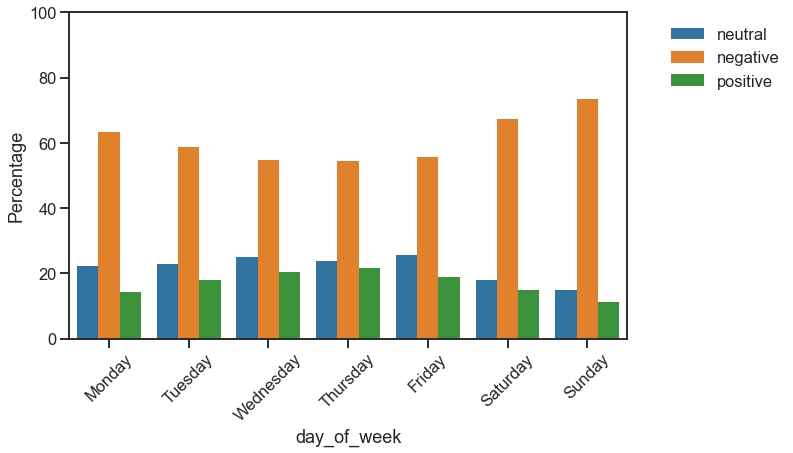

In [14]:
#Sentiment distribution across different day in week
dow = (tweet.groupby('day_of_week')['airline_sentiment'].value_counts(
    normalize=True)*100).rename('Percentage').reset_index()

plt.figure(figsize=(10, 6))
t = sns.barplot(y='Percentage', hue='airline_sentiment', x='day_of_week',
                data=dow, hue_order=['neutral', 'negative', 'positive'],
               order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                  'Friday', 'Saturday', 'Sunday'])

t.set_xticklabels(t.get_xticklabels(), rotation=45)
t.set_ylim(0,100)

plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right');

Negative sentiment ratio increase slightly from weekdays to weekends, hence it could be a good predictor.

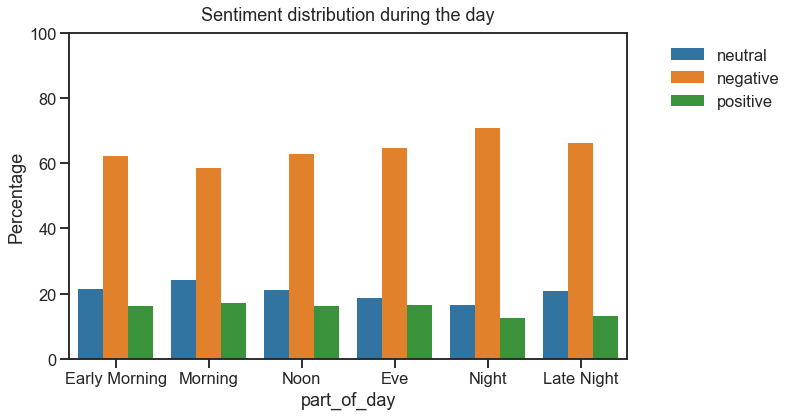

In [113]:
# Sentiment distribution during a day

pod = (tweet.groupby('part_of_day')['airline_sentiment'].value_counts(
    normalize=True)*100).rename('Percentage').reset_index()

plt.figure(figsize=(10, 6))
t = sns.barplot(y='Percentage', hue='airline_sentiment', x='part_of_day',
                data=pod, hue_order=['neutral', 'negative', 'positive'],
               order = ['Early Morning','Morning','Noon','Eve','Night','Late Night'])

t.set_ylim(0,100)
t.set_title('Sentiment distribution during the day', y = 1.02)
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right');

Minimal variation of sentiment distribution has been observed during the day. Although negative sentiment were higher in the night, it was only single digit different from the average. Therefore the part of day may be a weak predictor.

### Retweet

In [16]:
tweet['retweet_count'].value_counts(normalize=True)*100

0     94.760929
1      4.371585
2      0.450820
3      0.150273
4      0.116120
5      0.034153
6      0.020492
7      0.020492
22     0.013661
9      0.006831
18     0.006831
32     0.006831
11     0.006831
8      0.006831
28     0.006831
44     0.006831
15     0.006831
31     0.006831
Name: retweet_count, dtype: float64

Majority of the tweet was not retweeted. Since its lack of the variance, "retweet_count" could rarely be a good predictor.

## A glimpse into airlines overview

Text(0.5, 1.02, 'Negative sentiment count of each airlines')

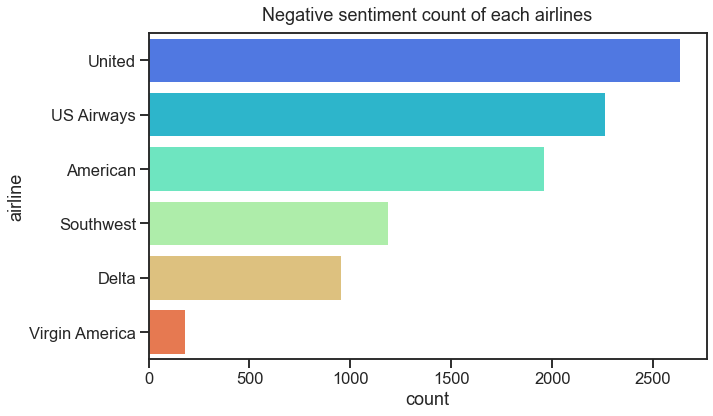

In [17]:
plt.figure(figsize=(10, 6))

g = sns.countplot(data=tweet[tweet['airline_sentiment'] == 'negative'], y='airline', palette='rainbow',
                  order=tweet[tweet['airline_sentiment'] == 'negative']['airline'].value_counts().index)
g.set_title('Negative sentiment count of each airlines', y = 1.02);


United Airlines received the highest negative tweet during 7 days period. However, looking only into negative sentiment count without normalizing with 7 days average number of flights can be misleading.

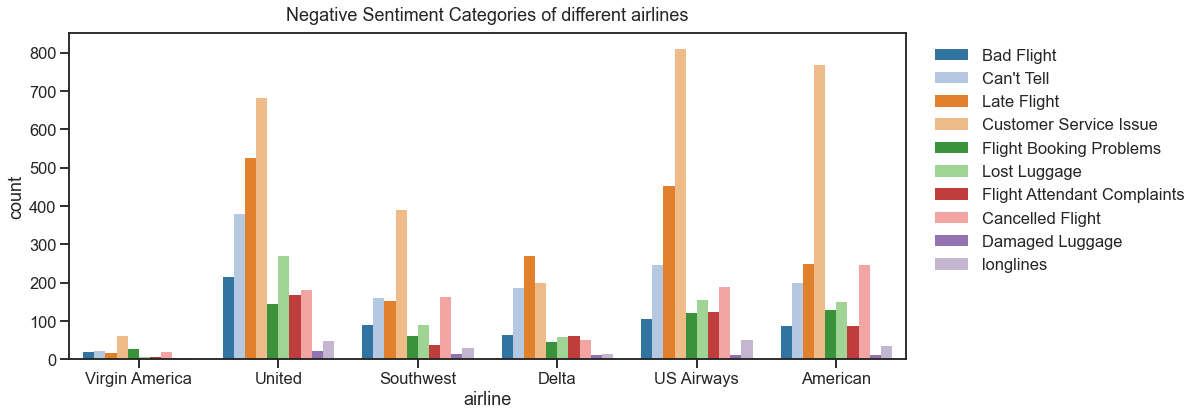

In [18]:
plt.figure(figsize=(15,6))
g = sns.countplot(x = 'airline', hue='negativereason', data = tweet, palette='tab20')
g.set_title('Negative Sentiment Categories of different airlines', y = 1.02)
plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right');
# g.set_xticklabels(g.get_xticklabels(), rotation = 90);

**Findings:**

1. All airlines were mainly complained about thier customer services. 
1. Only Delta airlines was complained about flight delay the most.

## Text data exploration

In [19]:
tweet['text'].apply(lambda x: x.split()[0]).unique()

array(['@VirginAmerica', '@virginamerica', 'I', 'Nice', '@VirginAmerica,',
       'Always', '.@VirginAmerica', '😎', "“@VirginAmerica:You've",
       'Awesome!', '👍👍✈️✈️💗', '@virginAmerica', '@virginamerica..',
       'Bruh', '“@VirginAmerica:', '@united', '@United', '@united.',
       '@United.', '.@united', '.Thnx', '@lindaSWC', '“@united:', 'Hey',
       'Decisions', 'Need', '@united:', 'Yes!!', 'Just', '@SouthwestAir',
       'Thank', 'Thanks', 'Flight', 'But', '@united,', 'The', 'UA3388',
       'BUT', '@united-rebooked', '.', '@United\u200b',
       '@united--excited', '@united...do', "“@united:That's", 'Only',
       'Very', 'Sorry,', '@united...lies', 'Reply', 'So', 'Meanwhile,',
       'fuck', "@united's", '@United,', 'Why', 'Can', 'we', 'There',
       'Really?', '2/2', '1/2', '.@united:', 'Cc', '@United:',
       'Hypocrisy', 'Is', 'Thx!', 'Wanted', '.@SouthwestAir', 'You',
       '@SouthwestAir:', '@SouthwestAir-', '^CB', '@southwestair', 'See',
       'Never', '“@SouthwestA

The text data, primary sources of our sentiment, contains noises such as emoji and hyperlink. Before proceeding to further analysis, I'll clean the data to make it more consistent and understandable by machine. 

In [20]:
def cleaning(text):
    """
    Take a raw tweet as input then clean it into ready-to-use text
    """
    
    # 1. Convert all text to lowercase,
    lower = text.lower()
    
    # 2. Remove hyperlink and special characters except hash sign
    no_html = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', lower)
    letters_only = re.sub("[^#a-zA-Z0-9]", " ", no_html).split()
    
    # 3. Segmenting hashtags
    normal_words = [word for word in letters_only if (word.startswith("#") == False)]
    hashtag_words = [word for word in letters_only if word.startswith("#")]
    hashtag_split = [segment(hashtag) for hashtag in hashtag_words]
    nohash_words = []
    count = 0
    for word in letters_only:
        if word not in hashtag_words:
            nohash_words.append(word)
        else:
            nohash_words.extend(hashtag_split[count])
            count += 1
    
    # 4. Remove mentioning specific airlines
    airline = ['virginamerica', 'united', 'unitedairways', 'southwest', 'southwestair' 'delta', 'usairways',
       'american','americanair','jetblue',]
    useful_words = [word for word in nohash_words if word not in airline]
    
    # 5. remove stopwords
    stops = set(stopwords.words('english'))
    meaningful_words = [word for word in useful_words if word not in stops]
    
    # 6. Lemmatize
    lem = WordNetLemmatizer()
    lem_words = [lem.lemmatize(word) for word in meaningful_words]
    
    return(" ".join(lem_words))

In [21]:
load()
tweet['text'] = tweet['text'].apply(cleaning)
tweet.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,char_length,word_length,day_of_week,part_of_day
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,dhepburn said,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada),35,4,Tuesday,Morning
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,plus added commercial,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada),72,9,Tuesday,Morning
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada),71,12,Tuesday,Morning


In [22]:
# Define a function to plot word cloud
def plot_cloud(wordcloud, title = ""):
    # Set figure size
    plt.figure(figsize=(15, 15))
    plt.title(f"{title}")
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [23]:
#Negative sentiment text
text_negative = ""
for tw in tweet[tweet['airline_sentiment'] == 'negative']['text']:
    text_negative += tw

#Positive sentiment text    
text_positive = ""
for tw in tweet[tweet['airline_sentiment'] == 'positive']['text']:
    text_positive += tw
    
#Neutral sentiment text
text_neutral = ""
for tw in tweet[tweet['airline_sentiment'] == 'positive']['text']:
    text_neutral += tw

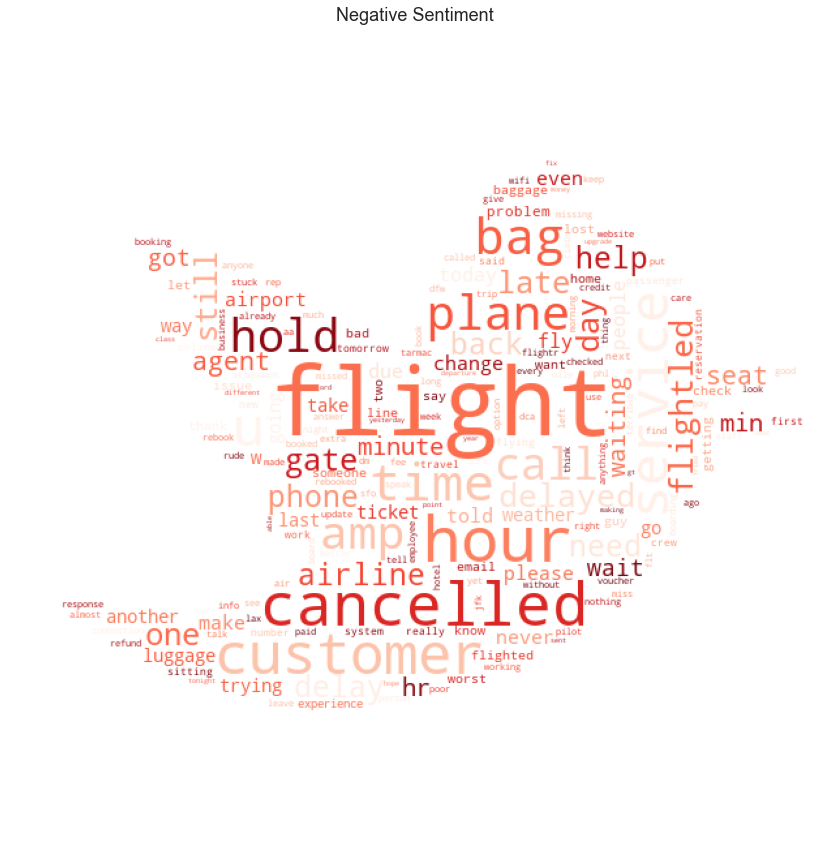

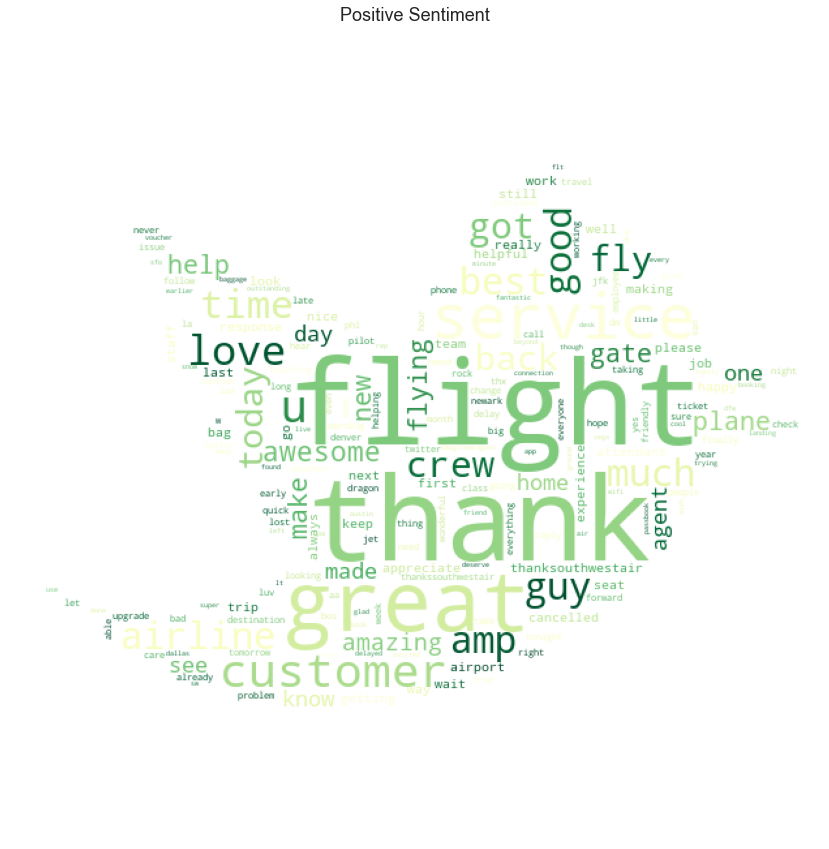

In [24]:
# Mask
mask = np.array(Image.open('../image/M2jeo.jpg'))

# Generate word cloud
wordcloud_negative = WordCloud(width=2000, height=2000, random_state=1, background_color='white',
                      colormap='Reds', collocations=False, stopwords=STOPWORDS, mask=mask).generate(text_negative)

wordcloud_positive = WordCloud(width=2000, height=2000, random_state=1, background_color='white',
                      colormap='YlGn', collocations=False, stopwords=STOPWORDS, mask=mask).generate(text_positive)

wordcloud_neutral = WordCloud(width=2000, height=2000, random_state=1, background_color='white',
                      colormap='rainbow', collocations=False, stopwords=STOPWORDS, mask=mask).generate(text_neutral)


# Plot
plot_cloud(wordcloud_negative, "Negative Sentiment")
plot_cloud(wordcloud_positive, "Positive Sentiment")

Findings:
- Positive sentiment keyword samples: `thank`, `love`, `awesome`, `great`, `best`, `good`
- Negative sentiment keyword samples: `cancelled`, `delayed`, `hour`, `customer`, `ticket`

Next, let's see which keywords are overlapping between two sentiment group

In [25]:
#Select only positive
tweet_positive = tweet[tweet['airline_sentiment'] == 'positive']

#Vectorize the text
vec_positive = CountVectorizer()
vec_positive.fit(tweet_positive['text'])

#Create a DataFrame sorted by word frequency
top_positive = pd.DataFrame(vec_positive.transform(tweet_positive['text']).toarray(
), columns=vec_positive.get_feature_names()).T.sum(axis=1).sort_values(ascending=False)


#Select only negative
tweet_negative = tweet[tweet['airline_sentiment'] == 'negative']

#Vectorize the text
vec_negative = CountVectorizer()
vec_negative.fit(tweet_negative['text'])

#Create a DataFrame sorted by word frequency
top_negative = pd.DataFrame(vec_negative.transform(tweet_negative['text']).toarray(
), columns=vec_negative.get_feature_names()).T.sum(axis=1).sort_values(ascending=False)

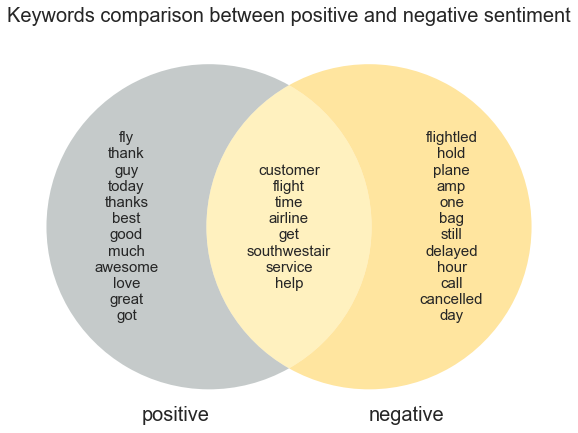

In [26]:
#Venn diagram display overlapping region of both category
plt.figure(figsize=(10, 10))
plt.title('Keywords comparison between positive and negative sentiment', fontsize=20)

set_positive = set(top_positive.index[:20])
set_negative = set(top_negative.index[:20])

venn = venn2([set_positive, set_negative], set_labels=['positive', 'negative'], set_colors=['#6e7c7c','#ffbe0f'])

venn.get_label_by_id('100').set_text(
    '\n'.join(map(str, set_positive-set_negative)))
venn.get_label_by_id('110').set_text(
    '\n'.join(map(str, set_positive & set_negative)))
venn.get_label_by_id('010').set_text(
    '\n'.join(map(str, set_negative-set_positive)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(15)
venn.get_label_by_id('110').set_size(15)
venn.get_label_by_id('010').set_size(15)

Highly overlapped keyword samples: `customer`, `flight`, `time`, `airline`, `service`

Removing these keywords could make the sentence less ambiguous, hence increasing the model accuracy

In [27]:
#Remove ambiguous keywords

def rm_intersect(text):
    """
    Take a raw tweet as input then clean it into ready-to-use text
    """
    text = text.split()
    
    useful_words = [word for word in text if word not in set_positive & set_negative]
    
    stops = set(stopwords.words('english'))
    meaningful_words = [word for word in useful_words if word not in stops]
    
    return(" ".join(meaningful_words))

tweet['text'] = tweet['text'].apply(rm_intersect)

# Model building

<img src="../images/algorithm_outline.png" />

I will be building 2 models ..

1. Metamodel : to handle metadata such as `tweet_created` (which was engineered into days_of_week and part_of_day), `char_length` and `word_length`
1. Textual model : to handle tweet messages in the columns `text`

and combining the prediction from both model to create the combined model to improve overall accuracy

## Train/Test split

In [28]:
# Our objective is to identify negative sentiment so I'll map negative with 1, others with 0
y = tweet['airline_sentiment'].map(lambda x: 1 if x == 'negative' else 0)
X = tweet[['char_length','word_length','day_of_week','part_of_day','text']]
y.value_counts(normalize=True)

1    0.626913
0    0.373087
Name: airline_sentiment, dtype: float64

From the dataset, over half of them are negative sentiment. Therefore the baseline accuracy (proportion of the majority class) that I'll be going to surpass is 62.6%

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.1,       # 90% training set / 10% test set
                                                   stratify=y,          # set stratify = y to maintain the same target distribution in the training and testing set
                                                   random_state=42)

In [30]:
print(X_train.shape, X_test.shape)

(13176, 5) (1464, 5)


## Metadata Modeling

### One Hot Encoding and Standardizing 

For the meta data, I got 2 numerical columns (char_length & word_length) and 2 categorical columns (day_of_week & part_of_day) which need different preprocessing steps as follow

- For the numerical attributes, I'll [standardize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) them.
- For the categorical attributes, I'll [one-hot encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)  them

In [31]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_columns = ['day_of_week', 'part_of_day']
ohe.fit(X_train[ohe_columns])

#Dropping the text columns
X_train_meta = X_train.drop(columns='text')

#One hot encoding the categorical columns
X_train_meta = pd.DataFrame(ohe.transform(X_train[ohe_columns]),
                           columns=ohe.get_feature_names(X_train[ohe_columns].columns), index= X_train.index)
X_train_meta = pd.concat([X_train_meta, X_train.drop(columns = ohe_columns+['text'])], axis=1)

# Standardize numerical columns
ss = StandardScaler()
ss.fit(X_train_meta[['char_length','word_length']])
X_train_meta.loc[:,['char_length','word_length']] = ss.transform(X_train_meta[['char_length','word_length']])

X_train_meta.head(3)
print(X_train_meta.shape)

(13176, 15)


In [32]:
#Dropping the text columns
X_test_meta = X_test.drop(columns='text')

#One hot encoding the categorical columns
X_test_meta = pd.DataFrame(ohe.transform(X_test[ohe_columns]),
                           columns=ohe.get_feature_names(X_test[ohe_columns].columns), index= X_test.index)
X_test_meta = pd.concat([X_test_meta, X_test.drop(columns = ohe_columns+['text'])], axis=1)

# Standardize numerical columns
X_test_meta.loc[:,['char_length','word_length']] = ss.transform(X_test_meta[['char_length','word_length']])

X_test_meta.head(3)

,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,part_of_day_Early Morning,part_of_day_Eve,part_of_day_Late Night,part_of_day_Morning,part_of_day_Night,part_of_day_Noon,char_length,word_length
9003,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.255555,-2.127696
14346,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.939033,0.774383
10876,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.076730,0.484175


In [33]:
lr_meta = LogisticRegression(random_state=42)
params_lr_meta = {
    'C' : np.logspace(-2,2,20)
}
grid_lr_meta = GridSearchCV(lr_meta, param_grid=params_lr_meta, cv=5)
grid_lr_meta.fit(X_train_meta,y_train)
print(f"Accuracy on the training set = {grid_lr_meta.score(X_train_meta,y_train)}")
print(f"Accuracy on the test set = {grid_lr_meta.score(X_test_meta,y_test)}")

Accuracy on the training set = 0.7087128111718276
Accuracy on the test set = 0.7213114754098361


In [34]:
grid_lr_meta.best_estimator_

LogisticRegression(C=0.29763514416313175, random_state=42)

In [35]:
rfc_meta = RandomForestClassifier(random_state=42)
params_rfc_meta = {
#     'n_estimators' : [100,150,200],
    'max_depth' : [30,40,50],
    'min_samples_leaf' : [30,35,40]
}
grid_rfc_meta = GridSearchCV(rfc_meta, param_grid=params_rfc_meta, cv=5)
grid_rfc_meta.fit(X_train_meta,y_train)
print(f"Accuracy on the training set = {grid_rfc_meta.score(X_train_meta,y_train)}")
print(f"Accuracy on the test set = {grid_rfc_meta.score(X_test_meta,y_test)}")

Accuracy on the training set = 0.7166818457802064
Accuracy on the test set = 0.717896174863388


In [36]:
grid_rfc_meta.best_estimator_

RandomForestClassifier(max_depth=30, min_samples_leaf=40, random_state=42)

For metadata model, LogisticRegression slightly outperform RandomForest.

## Text data Modelling

### Preparing Text data
For the text data, I'll be looking only to tweet message and following steps will be done to preprocess the text data before feeding into the model

1. [Vectorize the tweet](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) : Convert a collection of raw documents to a matrix of TF-IDF features.

In [37]:
X_train_text = X_train['text']
X_test_text = X_test['text']

In [38]:
# LR + TfidfVec

pipe_lr_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 10000))
])

pipe_lr_params = {
    'tvec__max_features': [4000,4500,5000],
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.70,0.75,0.80],
    'tvec__ngram_range': [(1,2)],
    'lr__C' : np.logspace(-2,0,10)

}

grid_lr_tvec = GridSearchCV(pipe_lr_tvec, param_grid=pipe_lr_params, cv=5)
grid_lr_tvec.fit(X_train_text,y_train)
print(f"Accuracy on the training set = {grid_lr_tvec.score(X_train_text,y_train)}")
print(f"Accuracy on the test set = {grid_lr_tvec.score(X_test_text,y_test)}")

#Save the model to pkl file
joblib.dump(grid_lr_tvec.best_estimator_, '../models/lr_tvec.pkl') 

Accuracy on the training set = 0.8721159684274439
Accuracy on the test set = 0.8346994535519126


['../models/lr_tvec.pkl']

In [39]:
grid_lr_tvec.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.7, max_features=4500, min_df=2,
                                 ngram_range=(1, 2))),
                ('lr', LogisticRegression(max_iter=10000))])

In [40]:
# RFC + TfidfVec

pipe_rfc_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))
])

pipe_rfc_params = {
    'tvec__max_features': [4000],
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.70],
    'tvec__ngram_range': [(1,2)],
    'rfc__n_estimators' : [70,100],
    'rfc__max_depth' : [200,250,300],
    'rfc__min_samples_leaf' : [3],
    'rfc__min_samples_split' : [5,10]

}

grid_rfc_tvec = GridSearchCV(pipe_rfc_tvec, param_grid=pipe_rfc_params, cv=5)
grid_rfc_tvec.fit(X_train_text,y_train)
print(f"Accuracy on the training set = {grid_rfc_tvec.score(X_train_text,y_train)}")
print(f"Accuracy on the test set = {grid_rfc_tvec.score(X_test_text,y_test)}")

#Save the model to pkl file
joblib.dump(grid_rfc_tvec.best_estimator_, '../models/rfc_tvec.pkl') 

Accuracy on the training set = 0.8622495446265938
Accuracy on the test set = 0.8121584699453552


['../models/rfc_tvec.pkl']

In [41]:
grid_rfc_tvec.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.7, max_features=4000, min_df=2,
                                 ngram_range=(1, 2))),
                ('rfc',
                 RandomForestClassifier(max_depth=300, min_samples_leaf=3,
                                        min_samples_split=10,
                                        random_state=42))])

Again, LogisticRegression perform slightly better than RandomForest.

## Combining two models

To combine the prediction from both models, I decided to train another LogisticRegression model on the prediction of metadata and text model to find optimal weighting.

In [42]:
# Get the best model
best_meta_model = grid_lr_meta.best_estimator_
best_text_model = grid_lr_tvec.best_estimator_

#### TRAINING SET ####
# Get prediction from both model
pred_meta = best_meta_model.predict_proba(X_train_meta)
pred_meta = np.array([pred[1] for pred in pred_meta])
pred_text = best_text_model.predict_proba(X_train_text)
pred_text = np.array([pred[1] for pred in pred_text])

#Using prediction from both model as input to a combined model
X_combine_train = np.column_stack((pred_meta,pred_text))


#### TESTING SET ####
# Get prediction from both model
pred_meta = best_meta_model.predict_proba(X_test_meta)
pred_meta = np.array([pred[1] for pred in pred_meta])
pred_text = best_text_model.predict_proba(X_test_text)
pred_text = np.array([pred[1] for pred in pred_text])

#Using prediction from both model as input to a combined model
X_combine_test = np.column_stack((pred_meta,pred_text))

In [43]:
combined_model = LogisticRegression(
    random_state=42, max_iter=10000, penalty='elasticnet', solver='saga', n_jobs=-1)

grid_combined = GridSearchCV(combined_model,
                             param_grid={
                                 'C': np.logspace(-4, 2, 20),
                                 'l1_ratio': np.arange(0, 1.1, 0.1),

                             },
                             cv=5)
grid_combined.fit(X_combine_train, y_train)
print(
    f"Accuracy on the training set = {grid_combined.score(X_combine_train,y_train)}")
print(
    f"Accuracy on the test set = {grid_combined.score(X_combine_test,y_test)}")

# Save the model to pkl file
joblib.dump(grid_combined.best_estimator_, '../models/combined_model.pkl')

Accuracy on the training set = 0.8774286581663631
Accuracy on the test set = 0.8422131147540983


['../models/combined_model.pkl']

In [44]:
grid_combined.best_estimator_

LogisticRegression(C=0.615848211066026, l1_ratio=0.4, max_iter=10000, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')

In [45]:
print(f"Accuracy of the metamodel on the test set = {round(best_meta_model.score(X_test_meta,y_test),3)*100}%")
print(f"Accuracy of the texual model on the test set = {round(best_text_model.score(X_test_text,y_test),3)*100}%")
print(f"Accuracy of the combined model on the test set = {round(grid_combined.score(X_combine_test,y_test),3)*100}%")

Accuracy of the metamodel on the test set = 72.1%
Accuracy of the texual model on the test set = 83.5%
Accuracy of the combined model on the test set = 84.2%


In [46]:
weight_meta = np.exp(grid_combined.best_estimator_.coef_[0][0])
weight_text = np.exp(grid_combined.best_estimator_.coef_[0][1])

print(f"The combined model have given weight of {round(weight_meta)} to the metamodel and {round(weight_text)} to the texual model")
print(f"which was equal to {round(weight_meta*100/(weight_text+weight_meta),2)}% to the metamodel and {round(weight_text*100/(weight_text+weight_meta),2)}% to the texual model")

The combined model have given weight of 5 to the metamodel and 10848 to the texual model
which was equal to 0.05% to the metamodel and 99.95% to the texual model


From the weight given by the combined model, almost all knowledge and wisdom, the model has acquired from the data, came from the text not metadata.

# Model Evaluation

## Metadata model

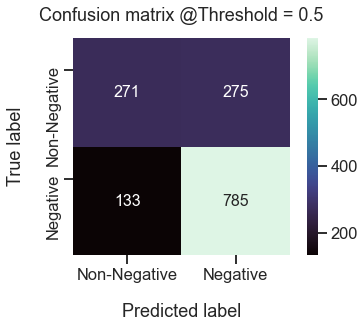

In [47]:
y_pred_meta = best_meta_model.predict(X_test_meta)
sns.heatmap(confusion_matrix(y_test, y_pred_meta), annot=True,
            cmap='mako', square=True, fmt='g', annot_kws={"size": 16},
           xticklabels = ['Non-Negative','Negative'], yticklabels=['Non-Negative','Negative'])
plt.xlabel('Predicted label',labelpad=20.0)
plt.xticks(ticks=[0.5,1.5],labels = ['Non-Negative','Negative'])
plt.yticks(ticks=[0.3,1.3],labels = ['Non-Negative','Negative'])
plt.ylabel('True label',labelpad=20.0);
plt.title('Confusion matrix @Threshold = 0.5',y=1.05);

## Text model

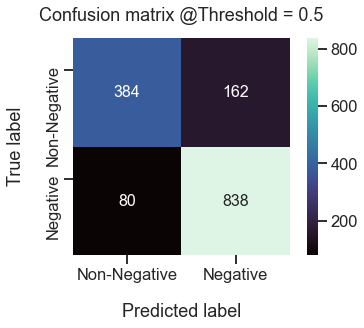

In [48]:
y_pred_text = best_text_model.predict(X_test_text)
sns.heatmap(confusion_matrix(y_test, y_pred_text), annot=True,
            cmap='mako', square=True, fmt='g', annot_kws={"size": 16},
           xticklabels = ['Non-Negative','Negative'], yticklabels=['Non-Negative','Negative'])
plt.xlabel('Predicted label',labelpad=20.0)
plt.xticks(ticks=[0.5,1.5],labels = ['Non-Negative','Negative'])
plt.yticks(ticks=[0.3,1.3],labels = ['Non-Negative','Negative'])
plt.ylabel('True label',labelpad=20.0);
plt.title('Confusion matrix @Threshold = 0.5',y=1.05);

## Combine model

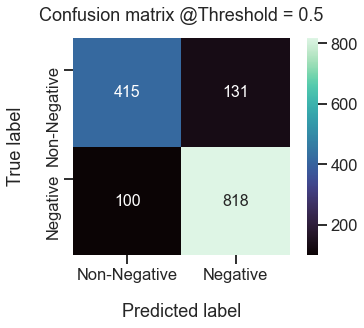

In [49]:
y_pred_combine = grid_combined.predict(X_combine_test)
sns.heatmap(confusion_matrix(y_test, y_pred_combine), annot=True,
            cmap='mako', square=True, fmt='g', annot_kws={"size": 16},
           xticklabels = ['Non-Negative','Negative'], yticklabels=['Non-Negative','Negative'])
plt.xlabel('Predicted label',labelpad=20.0)
plt.xticks(ticks=[0.5,1.5],labels = ['Non-Negative','Negative'])
plt.yticks(ticks=[0.3,1.3],labels = ['Non-Negative','Negative'])
plt.ylabel('True label',labelpad=20.0);
plt.title('Confusion matrix @Threshold = 0.5',y=1.05);

In [50]:
print(f"Accuracy of the metamodel on the test set = {round(best_meta_model.score(X_test_meta,y_test),3)*100}%")
print(f"Accuracy of the texual model on the test set = {round(best_text_model.score(X_test_text,y_test),3)*100}%")
print(f"Accuracy of the combined model on the test set = {round(grid_combined.score(X_combine_test,y_test),3)*100}%")

Accuracy of the metamodel on the test set = 72.1%
Accuracy of the texual model on the test set = 83.5%
Accuracy of the combined model on the test set = 84.2%


By combinining the prediction of metamodel and textual model, accuracy of combined model (84.2%) is slightly imprvoed from the textual model alone (83.5%). It can be infered that our metadata model, although is not very informative since the data was collected from relatively short time period (1 weeks), can be used to enhance the overall accuracy. Further improvement can be done by incorpating data from longer time period.

# Model inference

Since the text model was built based on logistic regression, the inference part can be easily explored by looking at the exponential of log coefficient of the model as shown below

In [57]:
#Create a dataframe containing 2,900 keywords and its coefficient
result = pd.DataFrame({'keywords' : best_text_model.steps[0][1].get_feature_names(),
              'coef' : best_text_model.steps[1][1].coef_[0]
             })

#take expontential transformation on the coefficient
result['exp_coef'] = result['coef'].apply(np.exp)
result.head()

,keywords,coef,exp_coef
0,00,0.494176,1.639147
1,000,-0.039249,0.961511
2,000 mile,0.316506,1.372324
3,02,0.271407,1.311809
4,03,-0.032399,0.968120


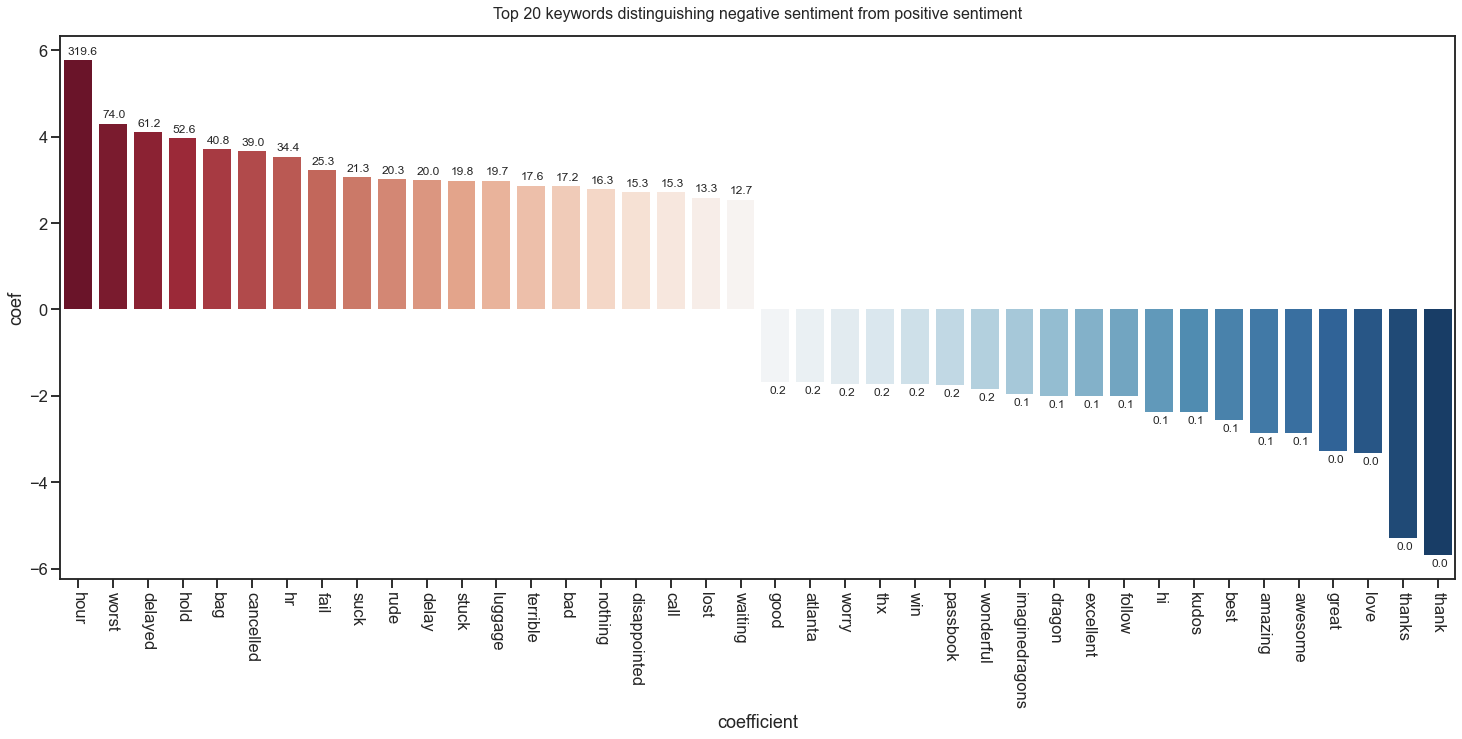

In [86]:
#Top 20 keywords for iPhone and Android
top_bot_20 = pd.concat([
    result.sort_values(by='coef', ascending=False)[:20],
    result.sort_values(by='coef', ascending=True)[:20]], axis=0)

top_bot_20 = top_bot_20.sort_values(by='coef',ascending=False)
top_bot_20

plt.figure(figsize = (25,10))
g = sns.barplot(data=top_bot_20,
            y='coef',
            x=top_bot_20.keywords,
           palette='RdBu')
g.set_title('Top 20 keywords distinguishing negative sentiment from positive sentiment',y=1.02,fontsize=16)
g.set_xticklabels(g.get_xticklabels(), rotation = 270)
g.set_xlabel('coefficient');


# Annotate the graph
for i, row in enumerate(top_bot_20.iterrows()):
    if i < 20:
        g.text(x=i-0.3, y=row[1][1]+0.2, s=round(row[1][2],1), ha='left', va='center',fontsize=12)
    else:
        g.text(x=i+0.3, y=row[1][1]-0.2, s=round(row[1][2],1), ha='right', va='center',fontsize=12)

By looking at the log coefficient I picked up...
- the top 20 keywords describing negative sentiment as plotted in red shaded bars
- the top 20 keywords indicating positive sentiment as plotted in blue shaded bars

We can see that tweets containing keywords such as **[hour, hr, delayed, delay, hold, cancelled] and/or [worst, fail, suck, rude, terrible, bad, disappointed]** will likely to be a negative sentiment tweet

# Testing the sentiment prediction

In [90]:
sample_tweet1 = "Customer services was horrible"
proba_1 = best_text_model.predict_proba([sample_tweet1])[0][1]
print(f'"{sample_tweet1}" has {round(proba_1,3)*100}% probability of being negative sentiment')

"Customer services was horrible" has 88.2% probability of being negative sentiment


In [91]:
sample_tweet2 = "The landing was perfect"
proba_2 = best_text_model.predict_proba([sample_tweet2])[0][1]
print(f'"{sample_tweet2}" has {round(proba_2,3)*100}% probability of being negative sentiment')

"The landing was perfect" has 20.3% probability of being negative sentiment


In [92]:
sample_tweet3 = "Although the departure was delayed, at least we are able to arrive on time"
proba_3 = best_text_model.predict_proba([sample_tweet3])[0][1]
print(f'"{sample_tweet3}" has {round(proba_3,2)*100}% probability of being negative sentiment')

"Although the departure was delayed, at least we are able to arrive on time" has 77.0% probability of being negative sentiment


The model can predict simple, less ambiguous correctly. However for the ambigous, neutral sentiment like sample_tweet3, the model will incorrectly predict it as a negative sentiment.

# Conclusion and future work

<img src="../images/Airline tweet sentiment analysis and topic modeling.jpg" />

## Conclusion

Baseline : the ratio of majority class (in our case = negative sentiment = 62.7%)

- From the metadata including `days of week`, `parts of day`, `char_length`, `word_length` , the metamodel (LogisticRegression) can learned and achieved 72.1 % accuracy
- From the textual data, the texual model can achieved 83.4% accuracy
- The combined model (which take prediction of both metamodel and textual model as input achieved 84.2% accuracy, an only marginal improvement from the textual model

## Limitation

- As demonstrated in the prediction test section, the textual model was not perform well on the ambiguous/ contrasting tweet. This happen because our model was trained using TF-IDF vectorizer, which employed a bag of words strategy.
- A bag of words doesn’t leverage co-occurrence statistics between words. In other words, it assumes all words are independent of each other. Thus it discards grammar, order, and structure in the text but track only occurrences.
- That's why in sample_tweet3 "Although the departure was delayed, at least we are able to arrive on time", it look at the present of keyword "delayed" and predict this tweet as negative sentiment despite of the rest of the sentence indicating ontime arrival.

## Further improvement ideas

For the data:

1. Due to the limited data collection period (only 1 week), the metadata was rarely improved overall accuracy. It would be great if we can expand data coverage to cover at least a year, so we can capture seasonality factor, holiday etc., to improve the predictive power.
1. The increasing in training set size will not only benefit the metamodel, actually it would allow us to build more complex deep learning model to tackle the drawback of a bag of words strategy

For the model:
1. Given a massive training set, I'll try to build deep learning model with the combination of Convolutional and LSTM layers to tackle complex relationship in a sentence. (Actually I have tried to built it using the existing training set in "EDA+DL" notebook)
1. Explore topic modeling technique to group and label negative sentiment into several subcategories for further training of a category classifier (see more in "Topic Modeling" notebook)